In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import os


In [51]:
# get file from parent directory
os.getcwd()
dir_path = os.getcwd() + r'\fa23-team\\'
# file_path = os.path.join(dir_path, 'data', 'cleaned_data.csv')
data = pd.read_csv(dir_path + 'census_bike_merged.csv')
data.head()

,tract,year,neighborhood,total_population,male,female,median_age,race_white,race_black,race_ai_alaskan,...,renters_owners_pre-2000_ratio,BFBL,BL,BLSL,SBL,SLM,SLMTC,SUP,total_built_all_lanes,cumulative_length
0,1001.0,2010,Dorchester,5617.0,0.481,0.519,23.9,0.063,0.638,0.012,...,0.700662,0.0,2493.815844,0.0,0.0,563.192706,0.0,0.0,3057.008550,3167.046929
1,1001.0,2011,Dorchester,5657.0,0.480,0.520,24.5,0.109,0.619,0.014,...,0.774003,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,3167.046929
2,1001.0,2012,Dorchester,6189.0,0.451,0.549,25.2,0.074,0.701,0.004,...,1.260708,0.0,851.779668,0.0,0.0,684.141817,0.0,0.0,1535.921485,4702.968414
3,1001.0,2013,Dorchester,6295.0,0.433,0.567,27.3,0.112,0.727,0.001,...,1.236902,0.0,36.450628,0.0,0.0,0.000000,0.0,0.0,36.450628,4739.419042
4,1001.0,2014,Dorchester,6371.0,0.455,0.545,31.2,0.131,0.750,0.001,...,0.946850,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,4739.419042


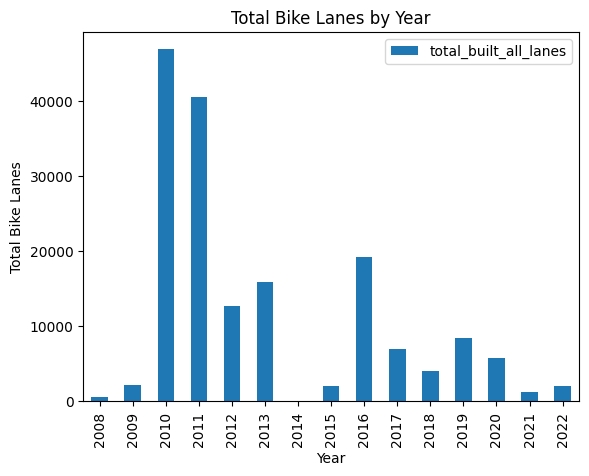

In [61]:
# checking for years with major changes in bike lanes
data[['year', 'total_built_all_lanes']].groupby('year').sum().plot(kind='bar')
plt.title('Total Bike Lanes by Year')
plt.xlabel('Year')
plt.ylabel('Total Bike Lanes')
plt.show()

In [52]:
# add a 'previous years built' columns for 'total_built_all_lanes'
data['previous_1y_built_all_lanes'] = data['total_built_all_lanes'].shift(1)
data['previous_2y_built_all_lanes'] = data['total_built_all_lanes'].shift(2)
data['previous_3y_built_all_lanes'] = data['total_built_all_lanes'].shift(3)
data['previous_4y_built_all_lanes'] = data['total_built_all_lanes'].shift(4)
data['previous_5y_built_all_lanes'] = data['total_built_all_lanes'].shift(5)

In [42]:
# Binary treatment variable
df_bike_lanes = data[data['previous_5y_built_all_lanes'] > 0]

# Check the size
print(f"Number of tract-years with >0 bike lanes: {len(df_bike_lanes)}")
print(f"Total number of tract-years: {len(data)}")
print(f"Proportion: {len(df_bike_lanes) / len(data)}")

Number of tract-years with >0 bike lanes: 155
Total number of tract-years: 696
Proportion: 0.22270114942528735


possible settings:
1. binary (added bike lanes > 0) vs ordinal (levels of added bike lanes); continuos might be too complicated
2. single year change (fewer observations, more interpretable) vs all years

<Axes: >

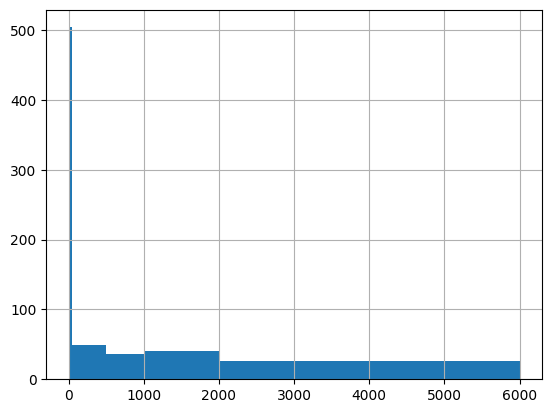

In [55]:
data['previous_5y_built_all_lanes'].hist(bins=[0,50,500,1000,2000,6000]);

#### binary DiD: single year, binary treatment

27

20
27 20


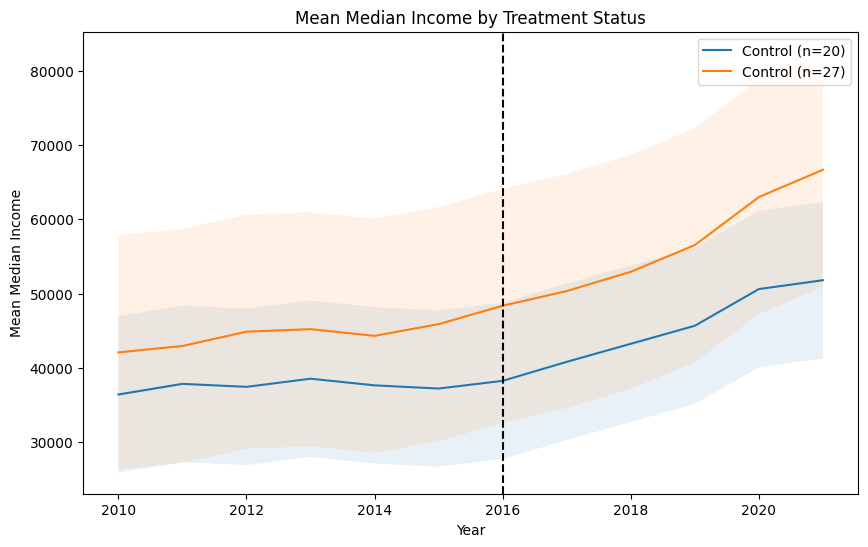

In [83]:
# create a treatment column to be 1 for all tracts for which 2016 had positive bike addition

# first, identify the tracts that had positive bike addition in 2016
treat_tracts = data[(data['total_built_all_lanes'] > 0)&(data['year']==2016)]['tract'].unique()
print(len(treat_tracts))
# then, create a treatment column that is 1 for all tracts that had positive bike addition in 2016
data['treatment'] = np.where(data['tract'].isin(treat_tracts), 1, 0)
n_control = data.loc[data['treatment']==0]['tract'].nunique()
n_treatment = data.loc[data['treatment']==1]['tract'].nunique()
print(n_control, n_treatment)

# compare the mean of 'median_income' between treatment and control group across all years
treat_income = data.groupby(['year','treatment'])['median_income'].mean().reset_index()

treatment = treat_income[treat_income['treatment'] == 1]
control = treat_income[treat_income['treatment'] == 0]


# plot the mean of 'median_income' between treatment and control group + confidence intervals + vertical dashed line at 2016
plt.figure(figsize=(10,6))
plt.plot(treatment['year'], treatment['median_income'], label=f'Control (n={n_treatment})')
# add confidence intervals
plt.fill_between(treatment['year'], treatment['median_income'] - 1.96*treatment['median_income'].std(), treatment['median_income'] + 1.96*treatment['median_income'].std(), alpha=0.1)
plt.plot(control['year'], control['median_income'], label=f'Control (n={n_control})')
# add confidence intervals
plt.fill_between(control['year'], control['median_income'] - 1.96*control['median_income'].std(), control['median_income'] + 1.96*control['median_income'].std(), alpha=0.1)
plt.axvline(x=2016, color='black', linestyle='--')
plt.legend()
plt.title('Mean Median Income by Treatment Status')
plt.xlabel('Year')
plt.ylabel('Mean Median Income')
plt.show()


In [ ]:
# Run the DiD model
import statsmodels.formula.api as smf
model = smf.ols('median_income ~ treatment*post_treatment + C(tract) + C(year)', data=data).fit()
print(model.summary())